#Brands table

In [173]:
# Import required python libraries
import json
import pandas as pd
import sqlite3

# Create a connection to the SQLite database called 'fetch'
conn = sqlite3.connect('fetch.db', timeout=10)

# Create a cursor object
cursor = conn.cursor()

# Drop the 'brands' table if it already exists
cursor.execute("DROP TABLE IF EXISTS brands")

# Commit the changes
conn.commit()

# Create the 'brands' table
create_table_query = '''
CREATE TABLE brands (
    _id TEXT PRIMARY KEY,
    barcode INTEGER,
    brandCode TEXT,
    category TEXT,
    categoryCode TEXT,
    cpgId TEXT,
    cpgRef TEXT,
    topBrand BOOLEAN,
    name TEXT
)
'''
cursor.execute(create_table_query)

conn.commit()

# Read the file line by line and parse each JSON object
data_brands = []
with open('brands.json', 'r') as file:
    for line in file:
        #break
        #data_list.append(data)
        data_brands.append(json.loads(line))

# Convert JSON data to a pandas DataFrame and handle nested fields
# Flatten the top-level fields and handle nested fields separately
for record in data_brands:
    _id = record.get('_id', {}).get('$oid')
    barcode = record.get('barcode')
    brandCode = record.get('brandCode')
    category = record.get('category')
    categoryCode = record.get('categoryCode')
    cpgId = record.get('cpg', {}).get('$id', {}).get('$oid')
    cpgRef = record.get('cpg', {}).get('$ref')
    #print(cpg)
    topBrand = record.get('topBrand')
    name = record.get('name')

    cursor.execute("""
        INSERT INTO brands (_id, barcode, brandCode, category, categoryCode, cpgId, cpgRef, topBrand, name)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (_id, barcode, brandCode, category, categoryCode, cpgId, cpgRef, topBrand, name))

    conn.commit()

In [174]:
# Write a SELECT query to confirm the data in the table
example_id = "601ac115be37ce2ead437551"
query = f"SELECT * FROM brands WHERE _id='{example_id}'"
result_df = pd.read_sql(query, conn)

# Display the queried data
print(result_df)

# Close the connection
conn.close()

                        _id       barcode brandCode category categoryCode  \
0  601ac115be37ce2ead437551  511111019862      None   Baking       BAKING   

                      cpgId cpgRef  topBrand                       name  
0  601ac114be37ce2ead437550   Cogs         0  test brand @1612366101024  


In [176]:
# Normalize JSON data to DataFrame
df = pd.json_normalize(data_brands)

# Rename a few columns for clarity
df_brands = df.rename(columns={'_id.$oid': 'id', 'cpg.$id.$oid': 'cpgId', 'cpg.$ref': 'cpgRef'})
df_brands.head()

# Extract relevant columns for the brand table
brand_columns = ['id', 'barcode', 'brandCode', 'category', 'categoryCode', 'cpgId', 'cpgRef', 'topBrand', 'name']

brands_df = df_brands[brand_columns]

# Print first few columns of DataFrame to verify
brands_df.head()

,id,barcode,brandCode,category,categoryCode,cpgId,cpgRef,topBrand,name
0,601ac115be37ce2ead437551,511111019862,NaN,Baking,BAKING,601ac114be37ce2ead437550,Cogs,False,test brand @1612366101024
1,601c5460be37ce2ead43755f,511111519928,STARBUCKS,Beverages,BEVERAGES,5332f5fbe4b03c9a25efd0ba,Cogs,False,Starbucks
2,601ac142be37ce2ead43755d,511111819905,TEST BRANDCODE @1612366146176,Baking,BAKING,601ac142be37ce2ead437559,Cogs,False,test brand @1612366146176
3,601ac142be37ce2ead43755a,511111519874,TEST BRANDCODE @1612366146051,Baking,BAKING,601ac142be37ce2ead437559,Cogs,False,test brand @1612366146051
4,601ac142be37ce2ead43755e,511111319917,TEST BRANDCODE @1612366146827,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,Cogs,False,test brand @1612366146827


###Data quality checks for brands table

In [177]:
# Summary of the DataFrame
brands_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1167 non-null   object
 1   barcode       1167 non-null   object
 2   brandCode     933 non-null    object
 3   category      1012 non-null   object
 4   categoryCode  517 non-null    object
 5   cpgId         1167 non-null   object
 6   cpgRef        1167 non-null   object
 7   topBrand      555 non-null    object
 8   name          1167 non-null   object
dtypes: object(9)
memory usage: 82.2+ KB


In [178]:
# To check the number of null values in each variable
brands_df.isnull().sum()

id                0
barcode           0
brandCode       234
category        155
categoryCode    650
cpgId             0
cpgRef            0
topBrand        612
name              0
dtype: int64

In [179]:
# To visualize the % of missing values for each variable
percentage_null_values = brands_df.isnull().mean()
for key,value in percentage_null_values.items():
  if value > 0:
    print(key,":",value*100)

brandCode : 20.051413881748072
category : 13.281919451585262
categoryCode : 55.69837189374465
topBrand : 52.44215938303341


In [180]:
# To check if there are any duplicate rows in the table
print(brands_df.duplicated().sum())
print(brands_df[brands_df.duplicated(subset=['id'])])

0
Empty DataFrame
Columns: [id, barcode, brandCode, category, categoryCode, cpgId, cpgRef, topBrand, name]
Index: []


In [181]:
# To list the unique values in category column
brands_df["category"].unique()

array(['Baking', 'Beverages', 'Candy & Sweets', 'Condiments & Sauces',
       'Canned Goods & Soups', nan, 'Magazines', 'Breakfast & Cereal',
       'Beer Wine Spirits', 'Health & Wellness', 'Beauty', 'Baby',
       'Frozen', 'Grocery', 'Snacks', 'Household', 'Personal Care',
       'Dairy', 'Cleaning & Home Improvement', 'Deli',
       'Beauty & Personal Care', 'Bread & Bakery', 'Outdoor',
       'Dairy & Refrigerated'], dtype=object)

In [182]:
# To check the consistency of 'topBrand'
print(brands_df['topBrand'].value_counts())

topBrand
False    524
True      31
Name: count, dtype: int64


In [183]:
# To check the consistency of 'category' and 'categoryCode'
category_consistency = brands_df.groupby('category')['categoryCode'].nunique()
print(category_consistency[category_consistency > 1])

Series([], Name: categoryCode, dtype: int64)


In [2]:
freq_category=100*(brands_df['category'].value_counts()/len(brands_df))
print(freq_category.map('{:,.2f}%'.format))

NameError: name 'brands_df' is not defined

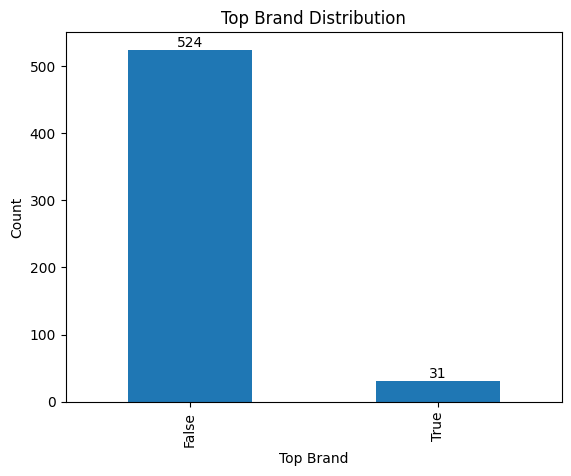

In [184]:
import matplotlib.pyplot as plt

# Value Distribution for 'topBrand' variable
value_counts = brands_df['topBrand'].value_counts()
ax = value_counts.plot(kind='bar')
plt.title('Top Brand Distribution')
plt.xlabel('Top Brand')
plt.ylabel('Count')

# Adding data labels on the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

plt.show()

#Users table

In [195]:
# Create a connection to the SQLite database
conn = sqlite3.connect('fetch.db', timeout=10)

# Create a cursor object
cursor = conn.cursor()

# Drop the 'users' table if it already exists
cursor.execute("DROP TABLE IF EXISTS users")

# Commit the changes
conn.commit()

# Create the 'users' table
create_table_query = '''
CREATE TABLE users (
    _id TEXT PRIMARY KEY,
    active BOOELAN,
    createdDate TEXT,
    lastLogin TEXT,
    role TEXT DEFAULT 'CONSUMER',
    signUpSource TEXT,
    state TEXT
)
'''
cursor.execute(create_table_query)

conn.commit()

data_users = []
with open('users.json', 'r') as file:
    for line in file:
        #data_list.append(data)
        data_users.append(json.loads(line))

# Normalize JSON data to DataFrame
df = pd.json_normalize(data_users)

# Rename '_id.$oid' to 'id' for clarity
df_users = df.rename(columns={'_id.$oid': '_id', 'createdDate.$date': 'createdDate', 'lastLogin.$date': 'lastLogin'})
df_users.head()

# Convert datetime fields to a readable format
df_users['createdDate'] = pd.to_datetime(df_users['createdDate'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
df_users['lastLogin'] = pd.to_datetime(df_users['lastLogin'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')

# Extract relevant columns for the brand table
user_columns = ['_id', 'active', 'createdDate', 'lastLogin', 'role', 'signUpSource', 'state']

duplicates = df_users.duplicated().sum()
print("Number of duplicate records:", duplicates)
print("Total number of records:", len(df_users))

dropped_df = df_users.drop_duplicates(subset=['_id'])

users_df = dropped_df[user_columns]
print("Number of unique records:", len(users_df))

users_df.head()

Number of duplicate records: 283
Total number of records: 495
Number of unique records: 212


,_id,active,createdDate,lastLogin,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04,2021-01-03 15:25:37,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30,2021-01-03 15:25:30,consumer,Email,WI
6,5ff1e1e8cfcf6c399c274ad9,True,2021-01-03 15:25:28,2021-01-03 15:25:28,consumer,Email,WI
7,5ff1e1b7cfcf6c399c274a5a,True,2021-01-03 15:24:39,2021-01-03 15:24:39,consumer,Email,WI
9,5ff1e1f1cfcf6c399c274b0b,True,2021-01-03 15:25:37,2021-01-03 15:25:37,consumer,Email,WI


In [196]:
# Iterate over the DataFrame to extract values from variables
for index, row in users_df.iterrows():
    _id = row['_id']
    createdDate = row['createdDate']
    lastLogin = row['lastLogin']
    active = row['active']
    role = row['role']
    signUpSource = row['signUpSource']
    state = row['state']

    # Insert the data into respective columns
    cursor.execute("""
        INSERT INTO users (_id, active, createdDate, lastLogin, role, signUpSource, state)
        VALUES (?, ?, ?, ?, ?, ?, ?)
    """, (_id, active, createdDate, lastLogin, role, signUpSource, state))

    conn.commit()

# Write a SELECT query to verfiy the data in table
query = f"SELECT * FROM users"
result_df = pd.read_sql(query, conn)

# Display the queried data
print(result_df)

# Close the connection
conn.close()

                          _id  active          createdDate  \
0    5ff1e194b6a9d73a3a9f1052       1  2021-01-03 15:24:04   
1    5ff1e1eacfcf6c399c274ae6       1  2021-01-03 15:25:30   
2    5ff1e1e8cfcf6c399c274ad9       1  2021-01-03 15:25:28   
3    5ff1e1b7cfcf6c399c274a5a       1  2021-01-03 15:24:39   
4    5ff1e1f1cfcf6c399c274b0b       1  2021-01-03 15:25:37   
..                        ...     ...                  ...   
207  5fc961c3b8cfca11a077dd33       1  2020-12-03 22:08:03   
208  5fa41775898c7a11a6bcef3e       1  2020-11-05 15:17:09   
209  5fa32b4d898c7a11a6bcebce       1  2020-11-04 22:29:33   
210  5964eb07e4b03efd0c0f267b       1  2017-07-11 15:13:11   
211  54943462e4b07e684157a532       1  2014-12-19 14:21:22   

               lastLogin         role signUpSource state  
0    2021-01-03 15:25:37     consumer        Email    WI  
1    2021-01-03 15:25:30     consumer        Email    WI  
2    2021-01-03 15:25:28     consumer        Email    WI  
3    2021-01-03 15:

##Data quality checks for users table

In [88]:
# View summary of the table
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212 entries, 0 to 475
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           212 non-null    object
 1   active        212 non-null    bool  
 2   createdDate   212 non-null    object
 3   lastLogin     172 non-null    object
 4   role          212 non-null    object
 5   signUpSource  207 non-null    object
 6   state         206 non-null    object
dtypes: bool(1), object(6)
memory usage: 19.9+ KB


In [89]:
# Check for duplicates
duplicates = users_df.duplicated().sum()
print(duplicates)

0


In [90]:
# Check for Missing Values
missing_values = users_df.isnull().sum()
print(missing_values)

_id              0
active           0
createdDate      0
lastLogin       40
role             0
signUpSource     5
state            6
dtype: int64


In [91]:
# Validate State Abbreviations
valid_states = set(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
                    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
                    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
                    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
                    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'])
invalid_states = users_df[~users_df['state'].isin(valid_states)]
print(invalid_states)

                          _id  active          createdDate  \
344  60145ff384231211ce796d51    True  2021-01-29 19:20:19   
375  60186237c8b50e11d8454d5f    True  2021-02-01 20:19:03   
422  5a43c08fe4b014fd6b6a0612    True  2017-12-27 15:47:27   
432  5fbc35711d967d1222cbfefc    True  2020-11-23 22:19:29   
455  5fa41775898c7a11a6bcef3e    True  2020-11-05 15:17:09   
475  54943462e4b07e684157a532    True  2014-12-19 14:21:22   

               lastLogin         role signUpSource state  
344                  NaN     consumer        Email   NaN  
375                  NaN     consumer        Email   NaN  
422  2021-02-12 16:22:37     consumer          NaN   NaN  
432  2021-02-26 04:25:51  fetch-staff        Email   NaN  
455  2021-03-04 16:02:02  fetch-staff        Email   NaN  
475  2021-03-05 16:52:23  fetch-staff          NaN   NaN  


In [92]:
# To identify unique values of categorical values
users_df["role"].unique()

array(['consumer', 'fetch-staff'], dtype=object)

In [93]:
users_df["signUpSource"].unique()

array(['Email', 'Google', nan], dtype=object)

In [94]:
users_df["state"].unique()

array(['WI', 'KY', 'AL', 'CO', 'IL', nan, 'OH', 'SC', 'NH'], dtype=object)

In [95]:
freq_source=100*(users_df['signUpSource'].value_counts()/len(users_df))
print(freq_source.map('{:,.2f}%'.format))

signUpSource
Email     96.23%
Google     1.42%
Name: count, dtype: object


In [96]:
freq_state=100*(users_df['state'].value_counts()/len(users_df))
print(freq_state.map('{:,.2f}%'.format))

state
WI    91.04%
AL     2.36%
IL     1.42%
KY     0.47%
CO     0.47%
OH     0.47%
SC     0.47%
NH     0.47%
Name: count, dtype: object


In [97]:
# Calculate the percentage of active users
total_users = len(users_df)
active_users = users_df['active'].sum()  # Since 'active' is a boolean, summing will give the count of True values
active_users_percentage = (active_users / total_users) * 100

print(f"Percentage of active users: {active_users_percentage:.2f}%")

Percentage of active users: 99.53%


In [98]:
# Check for createdDate after lastLogin
invalid_date_order = users_df[users_df['createdDate'] > users_df['lastLogin']]
print("Users with createdDate after lastLogin:")
print(invalid_date_order)

Users with createdDate after lastLogin:
Empty DataFrame
Columns: [_id, active, createdDate, lastLogin, role, signUpSource, state]
Index: []


#Receipts and Items tables

In [99]:
# Create a connection to the SQLite database
conn = sqlite3.connect('fetch.db')

# Create a cursor object
cursor = conn.cursor()

# Drop the 'receipts' table if it already exists
cursor.execute("DROP TABLE IF EXISTS receipts")

conn.commit()

# Create 'receipts' table
create_table_query = '''
CREATE TABLE receipts (
    receipt_id TEXT PRIMARY KEY,
    bonusPointsEarned INTEGER,
    bonusPointsEarnedReason TEXT,
    createDate TEXT,
    dateScanned TEXT,
    finishedDate TEXT,
    modifyDate TEXT,
    pointsAwardedDate TEXT,
    pointsEarned REAL,
    purchaseDate TEXT,
    purchasedItemCount INTEGER,
    rewardsReceiptStatus TEXT,
    totalSpent REAL,
    userId TEXT
)
'''
cursor.execute(create_table_query)

conn.commit()

# Drop the 'items' table if it already exists
cursor.execute("DROP TABLE IF EXISTS items")

conn.commit()

# Create 'items' table
create_table_query = '''
CREATE TABLE items (
    item_id INTEGER PRIMARY KEY AUTOINCREMENT,
    receipt_id TEXT ,
    barcode TEXT,
    description TEXT,
    finalPrice DECIMAL(10, 2),
    itemPrice DECIMAL(10, 2),
    needsFetchReview BOOLEAN,
    needsFetchReviewReason TEXT,
    partnerItemId TEXT,
    pointsNotAwardedReason TEXT,
    pointsPayerId TEXT,
    preventTargetGapPoints BOOLEAN,
    quantityPurchased INT,
    rewardsGroup TEXT,
    rewardsProductPartnerId TEXT,
    userFlaggedBarcode TEXT,
    userFlaggedDescription TEXT,
    userFlaggedNewItem BOOLEAN,
    userFlaggedPrice DECIMAL(10, 2),
    userFlaggedQuantity INT,
    competitiveProduct BOOLEAN,
    competitiveRewardsGroup TEXT,
    competitiveReceiptItemText TEXT,
    originalReceiptItemText TEXT,
    originalMetaBriteBarcode TEXT,
    originalMetaBriteDescription TEXT,
    originalMetaBriteQuantityPurchased INT,
    originalMetaBriteItemPrice DECIMAL(10, 2),
    FOREIGN KEY (receipt_id) REFERENCES receipts(id),
    FOREIGN KEY (barcode) REFERENCES brands(barcode)
)'''
cursor.execute(create_table_query)

# Commit the transaction
conn.commit()

In [100]:
# Read the JSON file
data_receipts = []
with open('receipts.json', 'r') as file:
    for line in file:
        data_receipts.append(json.loads(line))

# Normalize JSON data to DataFrame
df_receipts = pd.json_normalize(data_receipts)
df_receipts.head()

#Convert JSON data to a pandas DataFrame and handle nested fields
# Flatten the top-level fields and handle nested fields separately
for record in data_receipts:
    receipt_id = record.get('_id', {}).get('$oid')
    bonusPointsEarned = record.get('bonusPointsEarned')
    bonusPointsEarnedReason = record.get('bonusPointsEarnedReason')
    createDate = record.get('createDate', {}).get('$date')
    dateScanned = record.get('dateScanned', {}).get('$date')
    finishedDate = record.get('finishedDate', {}).get('$date')
    modifyDate = record.get('modifyDate', {}).get('$date')
    pointsAwardedDate = record.get('pointsAwardedDate', {}).get('$date')
    pointsEarned = record.get('pointsEarned')
    purchaseDate = record.get('purchaseDate', {}).get('$date')
    purchasedItemCount = record.get('purchasedItemCount')
    rewardsReceiptStatus = record.get('rewardsReceiptStatus')
    totalSpent = record.get('totalSpent')
    userId = record.get('userId')

    cursor.execute("""
        INSERT INTO receipts (receipt_id, bonusPointsEarned, bonusPointsEarnedReason, createDate, dateScanned, finishedDate,
                                  modifyDate, pointsAwardedDate, pointsEarned, purchaseDate, purchasedItemCount,
                                  rewardsReceiptStatus, totalSpent, userId)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (receipt_id, bonusPointsEarned, bonusPointsEarnedReason, createDate, dateScanned, finishedDate, modifyDate,
          pointsAwardedDate, pointsEarned, purchaseDate, purchasedItemCount, rewardsReceiptStatus, totalSpent, userId))

    conn.commit()

# # Write the SELECT query with a WHERE clause
# query = f"SELECT * FROM receipts LIMIT 10"
# result_df = pd.read_sql(query, conn)
# print(result_df)

    # Insert items into 'items'
    items = record.get('rewardsReceiptItemList', [])
    for item in items:
            receipt_id = record.get('_id', {}).get('$oid')
            barcode = item.get('barcode')
            description = item.get('description')
            finalPrice = item.get('finalPrice')
            itemPrice = item.get('itemPrice')
            needsFetchReview = item.get('needsFetchReview')
            needsFetchReviewReason = item.get('needsFetchReviewReason')
            partnerItemId = item.get('partnerItemId')
            pointsNotAwardedReason = item.get('pointsNotAwardedReason')
            pointsPayerId = item.get('pointsPayerId')
            preventTargetGapPoints = item.get('preventTargetGapPoints')
            quantityPurchased = item.get('quantityPurchased')
            rewardsGroup = item.get('rewardsGroup')
            rewardsProductPartnerId = item.get('rewardsProductPartnerId')
            userFlaggedBarcode = item.get('userFlaggedBarcode')
            userFlaggedDescription = item.get('userFlaggedDescription')
            userFlaggedNewItem = item.get('userFlaggedNewItem')
            userFlaggedPrice = item.get('userFlaggedPrice')
            userFlaggedQuantity = item.get('userFlaggedQuantity')
            competitiveProduct = item.get('competitiveProduct')
            competitiveRewardsGroup = item.get('competitiveRewardsGroup')
            competitiveReceiptItemText = item.get('competitiveReceiptItemText')
            originalReceiptItemText = item.get('originalReceiptItemText')
            originalMetaBriteBarcode = item.get('originalMetaBriteBarcode')
            originalMetaBriteDescription = item.get('originalMetaBriteDescription')
            originalMetaBriteQuantityPurchased = item.get('originalMetaBriteQuantityPurchased')
            originalMetaBriteItemPrice = item.get('originalMetaBriteItemPrice')


            cursor.execute("""
                INSERT INTO items (receipt_id, barcode, description, finalPrice, itemPrice, needsFetchReview,
                                   needsFetchReviewReason, partnerItemId,
                                   pointsNotAwardedReason, pointsPayerId, preventTargetGapPoints, quantityPurchased,
                                   rewardsGroup, rewardsProductPartnerId, userFlaggedBarcode, userFlaggedDescription,
                                   userFlaggedNewItem, userFlaggedPrice, userFlaggedQuantity, competitiveProduct,
                                   competitiveRewardsGroup, competitiveReceiptItemText, originalReceiptItemText, originalMetaBriteBarcode,
                                   originalMetaBriteDescription, originalMetaBriteQuantityPurchased,
                                   originalMetaBriteItemPrice)
                VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
            """, (receipt_id, barcode, description, finalPrice, itemPrice, needsFetchReview, needsFetchReviewReason, partnerItemId,
                  pointsNotAwardedReason, pointsPayerId, preventTargetGapPoints, quantityPurchased, rewardsGroup,
                  rewardsProductPartnerId, userFlaggedBarcode, userFlaggedDescription, userFlaggedNewItem,
                  userFlaggedPrice, userFlaggedQuantity, competitiveProduct, competitiveRewardsGroup,
                  competitiveReceiptItemText, originalReceiptItemText, originalMetaBriteBarcode, originalMetaBriteDescription,
                  originalMetaBriteQuantityPurchased, originalMetaBriteItemPrice))

            conn.commit()

query = f"SELECT * FROM receipts LIMIT 10"
result_df = pd.read_sql(query, conn)
print(result_df)

                 receipt_id  bonusPointsEarned  \
0  5ff1e1eb0a720f0523000575                500   
1  5ff1e1bb0a720f052300056b                150   
2  5ff1e1f10a720f052300057a                  5   
3  5ff1e1ee0a7214ada100056f                  5   
4  5ff1e1d20a7214ada1000561                  5   
5  5ff1e1e40a7214ada1000566                750   
6  5ff1e1cd0a720f052300056f                  5   
7  5ff1e1a40a720f0523000569                500   
8  5ff1e1ed0a7214ada100056e                  5   
9  5ff1e1eb0a7214ada100056b                250   

                             bonusPointsEarnedReason     createDate  \
0  Receipt number 2 completed, bonus point schedu...  1609687531000   
1  Receipt number 5 completed, bonus point schedu...  1609687483000   
2                         All-receipts receipt bonus  1609687537000   
3                         All-receipts receipt bonus  1609687534000   
4                         All-receipts receipt bonus  1609687506000   
5  Receipt number 1 com

In [101]:
query = f"SELECT * FROM receipts LIMIT 10"
result_df = pd.read_sql(query, conn)
print(result_df)

# Write the SELECT query with a WHERE clause
query = f"SELECT * FROM items LIMIT 10"
result_df = pd.read_sql(query, conn)
print(result_df)

conn.close()

                 receipt_id  bonusPointsEarned  \
0  5ff1e1eb0a720f0523000575                500   
1  5ff1e1bb0a720f052300056b                150   
2  5ff1e1f10a720f052300057a                  5   
3  5ff1e1ee0a7214ada100056f                  5   
4  5ff1e1d20a7214ada1000561                  5   
5  5ff1e1e40a7214ada1000566                750   
6  5ff1e1cd0a720f052300056f                  5   
7  5ff1e1a40a720f0523000569                500   
8  5ff1e1ed0a7214ada100056e                  5   
9  5ff1e1eb0a7214ada100056b                250   

                             bonusPointsEarnedReason     createDate  \
0  Receipt number 2 completed, bonus point schedu...  1609687531000   
1  Receipt number 5 completed, bonus point schedu...  1609687483000   
2                         All-receipts receipt bonus  1609687537000   
3                         All-receipts receipt bonus  1609687534000   
4                         All-receipts receipt bonus  1609687506000   
5  Receipt number 1 com

In [102]:
# Normalize JSON data to DataFrame
df_rc = pd.json_normalize(data_receipts)

# Rename a few columns for clarity
df_receipts = df_rc.rename(columns={'_id.$oid': 'receipt_id', 'createDate.$date': 'createDate', 'dateScanned.$date': 'dateScanned',
                                  'finishedDate.$date' : 'finishedDate', 'modifyDate.$date' : 'modifyDate', 'pointsAwardedDate.$date' : 'pointsAwardedDate',
                                  'purchaseDate.$date' : 'purchaseDate'})


# Convert datetime fields to a readable format
df_receipts['createDate'] = pd.to_datetime(df_receipts['createDate'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
df_receipts['dateScanned'] = pd.to_datetime(df_receipts['dateScanned'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
df_receipts['finishedDate'] = pd.to_datetime(df_receipts['finishedDate'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
df_receipts['modifyDate'] = pd.to_datetime(df_receipts['modifyDate'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
df_receipts['pointsAwardedDate'] = pd.to_datetime(df_receipts['pointsAwardedDate'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')
df_receipts['purchaseDate'] = pd.to_datetime(df_receipts['purchaseDate'], unit='ms').dt.strftime('%Y-%m-%d %H:%M:%S')

# Extract relevant columns for the 'receipts' table
receipts_columns = ['receipt_id', 'bonusPointsEarned', 'bonusPointsEarnedReason','createDate','dateScanned','finishedDate','modifyDate','pointsAwardedDate','pointsEarned','purchaseDate',
                    'purchasedItemCount','rewardsReceiptStatus','totalSpent','userId']

receipts_df = df_receipts[receipts_columns]

# Print the DataFrame to verify
receipts_df.head()


,receipt_id,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,2021-01-03 15:25:37,2021-01-03 15:25:37,NaN,2021-01-03 15:25:42,NaN,5,2021-01-03 00:00:00,1.0,REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,2021-01-03 15:25:06,2021-01-03 15:25:06,2021-01-03 15:25:11,2021-01-03 15:25:11,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2.0,FINISHED,1.00,5ff1e194b6a9d73a3a9f1052


###Data quality for receipts table

In [103]:
# To get summary of the data
receipts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   receipt_id               1119 non-null   object 
 1   bonusPointsEarned        544 non-null    float64
 2   bonusPointsEarnedReason  544 non-null    object 
 3   createDate               1119 non-null   object 
 4   dateScanned              1119 non-null   object 
 5   finishedDate             568 non-null    object 
 6   modifyDate               1119 non-null   object 
 7   pointsAwardedDate        537 non-null    object 
 8   pointsEarned             609 non-null    object 
 9   purchaseDate             671 non-null    object 
 10  purchasedItemCount       635 non-null    float64
 11  rewardsReceiptStatus     1119 non-null   object 
 12  totalSpent               684 non-null    object 
 13  userId                   1119 non-null   object 
dtypes: float64(2), object(12

In [104]:
# To check statistical summary of the data
summary_stats = receipts_df.describe()
print(summary_stats)

       bonusPointsEarned  purchasedItemCount
count         544.000000           635.00000
mean          238.893382            14.75748
std           299.091731            61.13424
min             5.000000             0.00000
25%             5.000000             1.00000
50%            45.000000             2.00000
75%           500.000000             5.00000
max           750.000000           689.00000


In [105]:
# Check for missing values
missing_values = receipts_df.isnull().sum()
print(missing_values)

receipt_id                   0
bonusPointsEarned          575
bonusPointsEarnedReason    575
createDate                   0
dateScanned                  0
finishedDate               551
modifyDate                   0
pointsAwardedDate          582
pointsEarned               510
purchaseDate               448
purchasedItemCount         484
rewardsReceiptStatus         0
totalSpent                 435
userId                       0
dtype: int64


In [106]:
# Check for duplicates
duplicates = receipts_df['receipt_id'].duplicated().sum()
print(f"Duplicate receipt_ids: {duplicates}")

Duplicate receipt_ids: 0


In [107]:
# Logical checks for date fields
invalid_date_sequence = receipts_df[receipts_df['dateScanned'] > receipts_df['finishedDate']]
print(f"Invalid date sequence count: {len(invalid_date_sequence)}")

Invalid date sequence count: 0


In [108]:
# Convert relevant columns to numeric, forcing errors to NaN
receipts_df['bonusPointsEarned'] = pd.to_numeric(receipts_df['bonusPointsEarned'], errors='coerce')
receipts_df['pointsEarned'] = pd.to_numeric(receipts_df['pointsEarned'], errors='coerce')
receipts_df['totalSpent'] = pd.to_numeric(receipts_df['totalSpent'], errors='coerce')
receipts_df['purchasedItemCount'] = pd.to_numeric(receipts_df['purchasedItemCount'], errors='coerce')

# After conversion, check for negative or unrealistic values
negative_values = receipts_df[(receipts_df['bonusPointsEarned'] < 0) | (receipts_df['pointsEarned'] < 0) |
                              (receipts_df['totalSpent'] < 0) | (receipts_df['purchasedItemCount'] < 0)]

print(f"Rows with negative values: {len(negative_values)}")

Rows with negative values: 0


<ipython-input-108-4cc7ed5d37bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  receipts_df['bonusPointsEarned'] = pd.to_numeric(receipts_df['bonusPointsEarned'], errors='coerce')
<ipython-input-108-4cc7ed5d37bd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  receipts_df['pointsEarned'] = pd.to_numeric(receipts_df['pointsEarned'], errors='coerce')
<ipython-input-108-4cc7ed5d37bd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [109]:
# List unique values to check for inconsistencies
print(receipts_df['bonusPointsEarnedReason'].unique())
print(receipts_df['rewardsReceiptStatus'].unique())

['Receipt number 2 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)'
 'Receipt number 5 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)'
 'All-receipts receipt bonus'
 'Receipt number 1 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)'
 'Receipt number 3 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)'
 'Receipt number 6 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)'
 'Receipt number 4 completed, bonus point schedule DEFAULT (5cefdcacf3693e0b50e83a36)'
 nan 'COMPLETE_PARTNER_RECEIPT' 'COMPLETE_NONPARTNER_RECEIPT']
['FINISHED' 'REJECTED' 'FLAGGED' 'SUBMITTED' 'PENDING']


In [110]:
# Consistency check between related fields
zero_values = receipts_df[(receipts_df['totalSpent'] == 0) | (receipts_df['purchasedItemCount'] == 0)]
print(f"Rows with zero values in totalSpent or purchasedItemCount: {len(zero_values)}")

Rows with zero values in totalSpent or purchasedItemCount: 15


##SQL Queries

Q1

In [159]:
def get_top_5_brands_by_receipts():
    # Connect to the SQLite database
    conn = sqlite3.connect('fetch.db')
    cursor = conn.cursor()

    # SQL query to find the most recent month
    recent_month_query = """
    SELECT strftime('%Y-%m', datetime(MAX(dateScanned) / 1000, 'unixepoch')) as recent_month
    FROM receipts;
    """

    # Execute the query and get the most recent month
    cursor.execute(recent_month_query)
    recent_month = cursor.fetchone()[0]

    print(recent_month)

    # SQL query to get the top 5 brands by receipts scanned for the most recent month
    top_5_brands_query = f"""
    SELECT b.name, COUNT(distinct r.receipt_id) as cnt
    FROM receipts r
    JOIN items i ON r.receipt_id = i.receipt_id
    JOIN brands b ON i.barcode = b.barcode
    WHERE strftime('%Y-%m', datetime((r.dateScanned) / 1000, 'unixepoch')) = '{'2021-01'}'
    GROUP BY b.name
    ORDER BY cnt DESC
    LIMIT 5;
    """

    # Execute the query and fetch the results
    cursor.execute(top_5_brands_query)
    top_5_brands = cursor.fetchall()

    # Convert results to a DataFrame for better readability
    df_top_5_brands = pd.DataFrame(top_5_brands, columns=['b.name', 'count'])

    # Close the connection
    conn.close()

    return df_top_5_brands

# Get the top 5 brands by receipts scanned for the most recent month
df_top_5_brands = get_top_5_brands_by_receipts()
print(df_top_5_brands)

2021-03
                  b.name  count
0               Tostitos     11
1                Swanson     11
2  Cracker Barrel Cheese     10
3                  Prego      4
4        Diet Chris Cola      4


Q3

In [161]:
def compare_average_spend():
    # Connect to the SQLite database
    conn = sqlite3.connect('fetch.db')
    cursor = conn.cursor()

    # SQL query to calculate the average spend for 'Accepted' and 'Rejected' receipts
    query = '''
        SELECT rewardsReceiptStatus, AVG(totalSpent) as average_spend
        FROM receipts
        WHERE rewardsReceiptStatus IN ('FINISHED', 'REJECTED')
        GROUP BY rewardsReceiptStatus
    '''

    # Execute the query
    cursor.execute(query)
    results = cursor.fetchall()

    # Print the results
    for row in results:
        print(f"Status: {row[0]}, Average Spend: {row[1]}")

    # Close the connection
    conn.close()

# Call the function to compare the average spend
compare_average_spend()

Status: FINISHED, Average Spend: 80.85430501930502
Status: REJECTED, Average Spend: 23.326056338028184


Q4

In [162]:
import sqlite3

def compare_total_items_purchased():
    # Connect to the SQLite database
    conn = sqlite3.connect('fetch.db')
    cursor = conn.cursor()

    # SQL query to calculate the total number of items purchased for 'FINISHED' and 'REJECTED' receipts
    query = '''
        SELECT rewardsReceiptStatus, SUM(purchasedItemCount) as total_items_purchased
        FROM receipts
        WHERE rewardsReceiptStatus IN ('FINISHED', 'REJECTED')
        GROUP BY rewardsReceiptStatus
    '''

    # Execute the query
    cursor.execute(query)
    results = cursor.fetchall()

    # Print the results
    for row in results:
        print(f"Status: {row[0]}, Total Items Purchased: {row[1]}")

    # Close the connection
    conn.close()

# Call the function to compare the total items purchased
compare_total_items_purchased()


Status: FINISHED, Total Items Purchased: 8184
Status: REJECTED, Total Items Purchased: 173


Q5

In [206]:
import sqlite3
from datetime import datetime, timedelta

# Connect to your SQLite database
conn = sqlite3.connect('fetch.db')
cursor = conn.cursor()

# Define the SQL query to fetch the maximum createdDate using SQLite functions
max_created_query = """
SELECT max(createdDate)
FROM users;
"""

#result_df = pd.read_sql(max_created_query, conn)
#print(result_df)

# Execute the query to get the maximum createdDate
cursor.execute(max_created_query)
max_created_date = cursor.fetchone()[0]

# Calculate 6 months ago from the max_created_date
if max_created_date:
    six_months_ago = (datetime.strptime(max_created_date, '%Y-%m-%d %H:%M:%S') - timedelta(days=180)).strftime('%Y-%m-%d %H:%M:%S')
    print(f"Date 6 months ago from {max_created_date}: {six_months_ago}")
else:
    print("No data found in the users table.")

# SQL query to find the brand with the most spend among users created in the past 6 months
query = '''
    SELECT b.name, SUM(r.totalSpent) as total_spent
    FROM users u
    JOIN receipts r ON u._id = r.userId
    JOIN items i ON r.receipt_id = i.receipt_id
    JOIN brands b ON i.barcode = b.barcode
    WHERE datetime((u.createdDate)/1000, 'unixepoch') >= '{six_months_ago}'
    GROUP BY b.name
    ORDER BY total_spent DESC
    LIMIT 1
'''

# # Execute the query
# cursor.execute(query)
# brand = cursor.fetchone()[0]

result_df = pd.read_sql(query, conn)
print(result_df)

# Don't forget to close the connection
conn.close()


Date 6 months ago from 2021-02-12 14:11:06: 2020-08-16 14:11:06
Empty DataFrame
Columns: [name, total_spent]
Index: []


Q6

In [208]:
import sqlite3
from datetime import datetime, timedelta

# Connect to your SQLite database
conn = sqlite3.connect('fetch.db')
cursor = conn.cursor()

# Define the SQL query to fetch the maximum createdDate using SQLite functions
max_created_query = """
SELECT max(createdDate)
FROM users;
"""

#result_df = pd.read_sql(max_created_query, conn)
#print(result_df)

# Execute the query to get the maximum createdDate
cursor.execute(max_created_query)
max_created_date = cursor.fetchone()[0]

# Calculate 6 months ago from the max_created_date
if max_created_date:
    six_months_ago = (datetime.strptime(max_created_date, '%Y-%m-%d %H:%M:%S') - timedelta(days=180)).strftime('%Y-%m-%d %H:%M:%S')
    print(f"Date 6 months ago from {max_created_date}: {six_months_ago}")
else:
    print("No data found in the users table.")

# SQL query to find the brand with the most spend among users created in the past 6 months
query = '''
    SELECT b.name, COUNT(*) as total_spent
    FROM users u
    JOIN receipts r ON u._id = r.userId
    JOIN items i ON r.receipt_id = i.receipt_id
    JOIN brands b ON i.barcode = b.barcode
    WHERE datetime((u.createdDate)/1000, 'unixepoch') >= '{six_months_ago}'
    GROUP BY b.name
    ORDER BY total_spent DESC
    LIMIT 1
'''

# # Execute the query
# cursor.execute(query)
# brand = cursor.fetchone()[0]

result_df = pd.read_sql(query, conn)
print(result_df)

# Don't forget to close the connection
conn.close()


Date 6 months ago from 2021-02-12 14:11:06: 2020-08-16 14:11:06
Empty DataFrame
Columns: [name, total_spent]
Index: []
